### Demonstrating fast KDTree point density calculation

I use pandas and basemap for sanity, but they are not required.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import OA_tools

from mpl_toolkits import basemap
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)


Read in simplified SPC tornado touchdown information:

In [2]:
torData = pd.read_csv('https://raw.githubusercontent.com/ahaberlie/hovmoller/master/torn_reports_minimal.csv',
                      delimiter=',',header=0)

lats = np.array(torDat['LAT'])
lons = np.array(torDat['LON'])

Set up basemap, project points

In [3]:
m = basemap.Basemap(
    width=4800000, height=3100000, projection='aea', resolution='l',
    lat_1=28.5, lat_2=44.5, lat_0=38.5, lon_0=-97.,area_thresh=5000)
    
x_proj, y_proj = m(lons, lats)
tor_points_proj = list(zip(x_proj, y_proj))


Demonstrating visually what KDTree can do.  In this example, select all points within 500 km of OKC

TODO: Somehow get pandas to play with KDTree so spatial subsetting can use point attributes

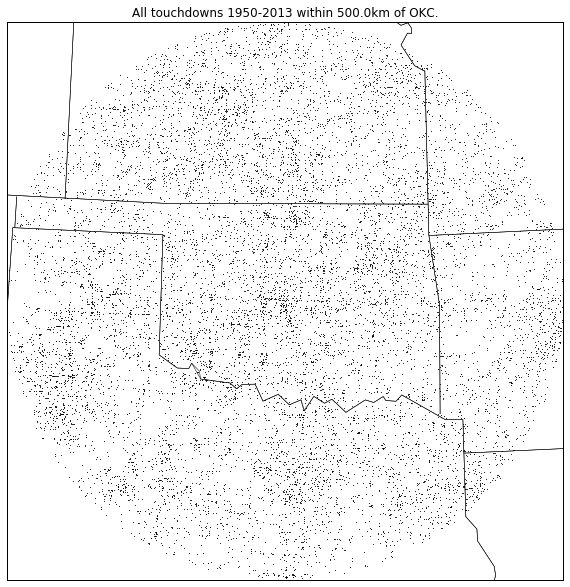

In [4]:
okc_pt = m(-97.5350, 35.4822)

radius = 500000 # meters

x_near, y_near = OA_tools.get_points_within_r(okc_pt, tor_points_proj, radius, return_idx=True) # KDTree powered

m.plot(x_near, y_near,'k.',markersize=1)

xmin = np.min(x_near)
xmax = np.max(x_near)
ymin = np.min(y_near)
ymax = np.max(y_near)
plt.axis([xmin, xmax, ymin, ymax]) #zoom in to radius

m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title("All touchdowns 1950-2013 within " + str(round(radius / 1000,0)) + "km of OKC.")

Define a search radius for creating density map that extends from the center of each grid cell

A count of points within this radius is calculated

In this example, divide by area searched, multiply to turn units into square kilometers, use that as grid cell value

(array([ 1312.,   704.,   766.,   958.,  1270.,  1744.,  1438.,  1088.,
          688.,   233.]),
 array([ 0.        ,  0.00280749,  0.00561499,  0.00842248,  0.01122997,
         0.01403747,  0.01684496,  0.01965245,  0.02245995,  0.02526744,
         0.02807493]),
 <a list of 10 Patch objects>)

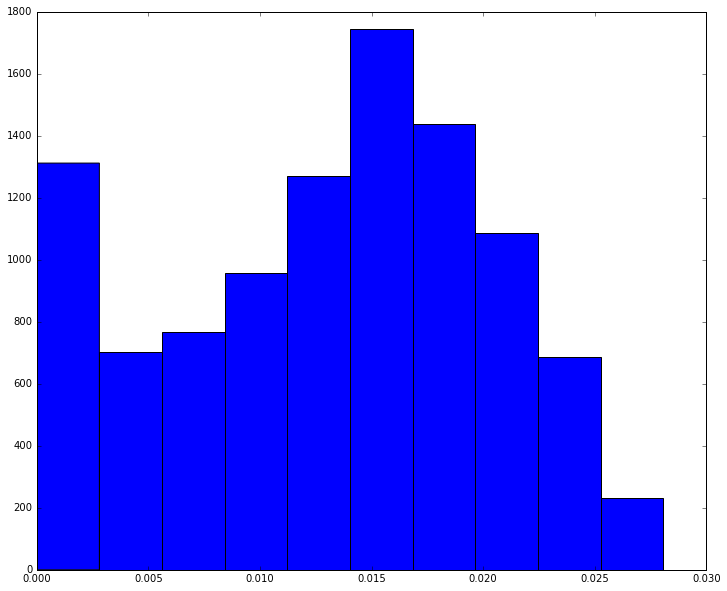

In [5]:
search_radius = 100000
search_area = np.pi * search_radius**2

x_res = y_res = 10000

b_box = OA_tools.get_boundary_coords(x_near, y_near) # convienent for calculations
gx, gy = OA_tools.generate_grid(x_res, y_res, b_box) # based on range of x,y values and desired resolution
                                                     # generate grid cells across domain
    
grid_points = OA_tools.generate_grid_coords(gx, gy)  # to calculate point density, generate list of grid point centers

counts = OA_tools.get_point_count_within_r(grid_points, list(zip(x_near, y_near)), search_radius)

density = counts / search_area * (1000**2)

plt.hist(density) # plot some stats 

Turn density array into a 2d image and plot!

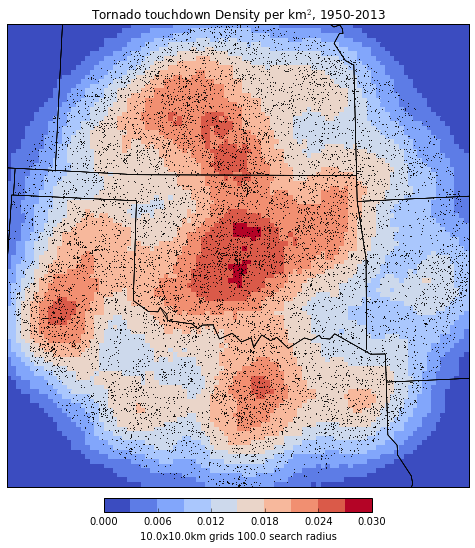

In [6]:
x_steps, y_steps = OA_tools.get_xy_steps(b_box, x_res, y_res)
vals = np.array(density).reshape(y_steps, x_steps)

levels = MaxNLocator(nbins=10).tick_values(np.min(vals), np.max(vals))

cmap = plt.get_cmap('coolwarm')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.pcolormesh(gx, gy, vals, cmap=cmap, norm=norm)
m.drawstates()

m.plot(x_near, y_near,'k.',markersize=1)
plt.axis([xmin, xmax, ymin, ymax]) #zoom in to radius
m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title("Tornado touchdown Density per km" + r"$^2$" + ", 1950-2013")
cbar = plt.colorbar(shrink=.4,pad=.02,orientation='horizontal')
cbar.set_label(str(x_res/1000) + "x" + str(y_res/1000) + "km" + " grids " + str(search_radius/1000) + " search radius")

What about Boulder?

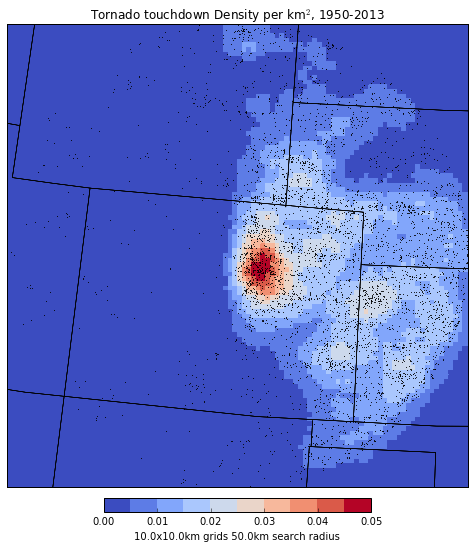

In [7]:
boulder_pt = m(-105.2519, 40.0274)
radius = 500000

x_near, y_near = OA_tools.get_points_within_r(boulder_pt, tor_points_proj, radius)

xmin = np.min(x_near)
xmax = np.max(x_near)
ymin = np.min(y_near)
ymax = np.max(y_near)

search_radius = 50000
search_area = np.pi * search_radius**2

x_res = y_res = 10000

b_box = OA_tools.get_boundary_coords(x_near, y_near)
gx, gy = OA_tools.generate_grid(x_res, y_res, b_box)
grid_points = OA_tools.generate_grid_coords(gx, gy)

counts = OA_tools.get_point_count_within_r(grid_points, list(zip(x_near, y_near)), search_radius)
counts = counts / search_area * (1000**2)

x_steps, y_steps = OA_tools.get_xy_steps(b_box, x_res, y_res)
vals = np.array(counts).reshape(y_steps, x_steps)

levels = MaxNLocator(nbins=10).tick_values(np.min(vals), np.max(vals))

cmap = plt.get_cmap('coolwarm')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.pcolormesh(gx, gy, vals, cmap=cmap, norm=norm)
plt.axis([xmin, xmax, ymin, ymax]) #zoom in to radius

m.drawstates()
m.plot(x_near, y_near,'k.',markersize=1)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
plt.title("Tornado touchdown Density per km" + r"$^2$" + ", 1950-2013")
cbar = plt.colorbar(shrink=.4,pad=.02,orientation='horizontal')
cbar.set_label(str(x_res/1000) + "x" + str(y_res/1000) + "km" + " grids " + str(search_radius/1000) + "km search radius")